In [1]:
!git clone https://github.com/haresh93/ERA-submissions.git
%cd ERA-submissions/S10/

Cloning into 'ERA-submissions'...
remote: Enumerating objects: 114, done.
remote: Counting objects: 100% (114/114), done.
remote: Compressing objects: 100% (89/89), done.
remote: Total 114 (delta 45), reused 59 (delta 20), pack-reused 0
Receiving objects: 100% (114/114), 506.55 KiB | 12.66 MiB/s, done.
Resolving deltas: 100% (45/45), done.
/content/ERA-submissions/S10


In [2]:
!pip3 install torch
!pip3 install torchvision
!pip3 install matplotlib
!pip3 install torchsummary
!pip3 install tqdm
!pip3 install albumentations
!pip3 install torch_lr_finder

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [4]:
cuda = torch.cuda.is_available()
print("Cuda Available: ", cuda)

device = torch.device("cuda" if cuda else "cpu")

Cuda Available:  True


In [5]:
# Train and Test Transforms
train_transforms = A.Compose([
        A.PadIfNeeded(min_height=40, min_width=40, value=(0.4914, 0.4822, 0.4465), p=1), # Padding with a border of 4 pixels
        A.RandomCrop(width=32, height=32),
        A.HorizontalFlip(p=0.5),
        A.CoarseDropout(max_holes = 1, max_height=8, max_width=8,
                       min_holes = 1, min_height=8, min_width=8, fill_value=(0.4914, 0.4822, 0.4465), mask_fill_value = None),
        A.Normalize( (0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
        ToTensorV2(),
])

test_transforms = A.Compose([
                                      A.Normalize( (0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
                                      ToTensorV2(),
])

In [6]:
# Train and Test Datasets
from dataset import Cifar10SearchDataset
train_dataset = Cifar10SearchDataset('~/data/CIFAR10', train=True, download=True,
                    transform=train_transforms)
test_dataset = Cifar10SearchDataset('~/data/CIFAR10', train=False, download=True,
                    transform=test_transforms)

100%|██████████| 170498071/170498071 [00:05<00:00, 28921630.24it/s]


Extracting /root/data/CIFAR10/cifar-10-python.tar.gz to /root/data/CIFAR10
Files already downloaded and verified


In [7]:
dataloader_args = dict(shuffle = True, batch_size = 512, num_workers = 4, pin_memory = True)

train_dataloader = torch.utils.data.DataLoader(train_dataset, **dataloader_args)

test_dataloader = torch.utils.data.DataLoader(test_dataset, **dataloader_args)

In [8]:
from custom_resnet import model_summary, Net

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)

model_summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,856
         MaxPool2d-5          [-1, 128, 16, 16]               0
       BatchNorm2d-6          [-1, 128, 16, 16]             256
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,584
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,584
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
           Conv2d-14          [-1, 256,

/usr/local/lib/python3.10/dist-packages/torch_lr_finder/lr_finder.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


  0%|          | 0/200 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 2.00E-02


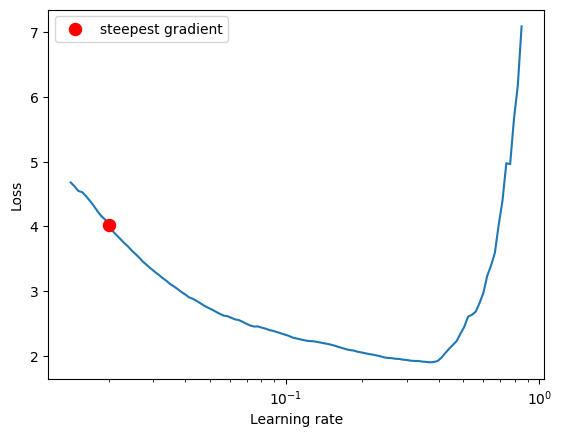

In [9]:
from torch_lr_finder import LRFinder

model = Net().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay = 0.0001)
criterion = nn.CrossEntropyLoss()
lr_finder = LRFinder(model, optimizer, criterion, device = 'cuda')
lr_finder.range_test(train_dataloader, end_lr = 10, num_iter = 200, step_mode = "exp")
lr_finder.plot()
lr_finder.reset()

In [10]:
from torch.optim.lr_scheduler import OneCycleLR
from train import model_train, model_test

EPOCHS = 24

scheduler = OneCycleLR(
    optimizer,
    max_lr = 0.018,
    steps_per_epoch=len(train_dataloader),
    epochs = EPOCHS,
    pct_start = 5/EPOCHS,
    div_factor=100,
    three_phase = False,
    final_div_factor=1000,
    anneal_strategy='linear'
)

for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    model_train(model, device, train_dataloader, optimizer, scheduler, criterion, epoch)
    model_test(model, device, test_dataloader, criterion)

EPOCH: 0


Train: Loss=1.0537 Batch_id=97 Accuracy=49.67: 100%|██████████| 98/98 [00:09<00:00, 10.67it/s]



Test set: Average loss: 0.0023, Accuracy: 6141/10000 (61.41%)

EPOCH: 1


Train: Loss=0.6720 Batch_id=97 Accuracy=67.81: 100%|██████████| 98/98 [00:09<00:00, 10.73it/s]



Test set: Average loss: 0.0019, Accuracy: 6840/10000 (68.40%)

EPOCH: 2


Train: Loss=0.7124 Batch_id=97 Accuracy=73.32: 100%|██████████| 98/98 [00:09<00:00, 10.89it/s]



Test set: Average loss: 0.0016, Accuracy: 7431/10000 (74.31%)

EPOCH: 3


Train: Loss=0.8068 Batch_id=97 Accuracy=76.77: 100%|██████████| 98/98 [00:09<00:00, 10.87it/s]



Test set: Average loss: 0.0012, Accuracy: 7943/10000 (79.43%)

EPOCH: 4


Train: Loss=0.7419 Batch_id=97 Accuracy=78.48: 100%|██████████| 98/98 [00:09<00:00, 10.49it/s]



Test set: Average loss: 0.0021, Accuracy: 6818/10000 (68.18%)

EPOCH: 5


Train: Loss=0.5565 Batch_id=97 Accuracy=81.40: 100%|██████████| 98/98 [00:09<00:00, 10.75it/s]



Test set: Average loss: 0.0012, Accuracy: 7954/10000 (79.54%)

EPOCH: 6


Train: Loss=0.6767 Batch_id=97 Accuracy=82.23: 100%|██████████| 98/98 [00:09<00:00, 10.83it/s]



Test set: Average loss: 0.0012, Accuracy: 8147/10000 (81.47%)

EPOCH: 7


Train: Loss=0.5451 Batch_id=97 Accuracy=83.65: 100%|██████████| 98/98 [00:09<00:00, 10.84it/s]



Test set: Average loss: 0.0009, Accuracy: 8381/10000 (83.81%)

EPOCH: 8


Train: Loss=0.3831 Batch_id=97 Accuracy=84.88: 100%|██████████| 98/98 [00:08<00:00, 10.98it/s]



Test set: Average loss: 0.0009, Accuracy: 8436/10000 (84.36%)

EPOCH: 9


Train: Loss=0.4835 Batch_id=97 Accuracy=85.49: 100%|██████████| 98/98 [00:08<00:00, 10.91it/s]



Test set: Average loss: 0.0011, Accuracy: 8235/10000 (82.35%)

EPOCH: 10


Train: Loss=0.3343 Batch_id=97 Accuracy=85.80: 100%|██████████| 98/98 [00:09<00:00, 10.78it/s]



Test set: Average loss: 0.0012, Accuracy: 8069/10000 (80.69%)

EPOCH: 11


Train: Loss=0.3700 Batch_id=97 Accuracy=86.80: 100%|██████████| 98/98 [00:09<00:00, 10.88it/s]



Test set: Average loss: 0.0012, Accuracy: 8039/10000 (80.39%)

EPOCH: 12


Train: Loss=0.3988 Batch_id=97 Accuracy=86.85: 100%|██████████| 98/98 [00:09<00:00, 10.74it/s]



Test set: Average loss: 0.0009, Accuracy: 8483/10000 (84.83%)

EPOCH: 13


Train: Loss=0.3639 Batch_id=97 Accuracy=87.80: 100%|██████████| 98/98 [00:09<00:00, 10.68it/s]



Test set: Average loss: 0.0011, Accuracy: 8204/10000 (82.04%)

EPOCH: 14


Train: Loss=0.3594 Batch_id=97 Accuracy=88.17: 100%|██████████| 98/98 [00:09<00:00, 10.80it/s]



Test set: Average loss: 0.0009, Accuracy: 8591/10000 (85.91%)

EPOCH: 15


Train: Loss=0.3582 Batch_id=97 Accuracy=88.65: 100%|██████████| 98/98 [00:09<00:00, 10.80it/s]



Test set: Average loss: 0.0008, Accuracy: 8641/10000 (86.41%)

EPOCH: 16


Train: Loss=0.3336 Batch_id=97 Accuracy=89.42: 100%|██████████| 98/98 [00:09<00:00, 10.77it/s]



Test set: Average loss: 0.0010, Accuracy: 8454/10000 (84.54%)

EPOCH: 17


Train: Loss=0.2740 Batch_id=97 Accuracy=89.99: 100%|██████████| 98/98 [00:09<00:00, 10.62it/s]



Test set: Average loss: 0.0008, Accuracy: 8701/10000 (87.01%)

EPOCH: 18


Train: Loss=0.3147 Batch_id=97 Accuracy=91.13: 100%|██████████| 98/98 [00:09<00:00, 10.67it/s]



Test set: Average loss: 0.0007, Accuracy: 8829/10000 (88.29%)

EPOCH: 19


Train: Loss=0.2505 Batch_id=97 Accuracy=91.92: 100%|██████████| 98/98 [00:09<00:00, 10.42it/s]



Test set: Average loss: 0.0006, Accuracy: 8955/10000 (89.55%)

EPOCH: 20


Train: Loss=0.2750 Batch_id=97 Accuracy=93.07: 100%|██████████| 98/98 [00:09<00:00, 10.78it/s]



Test set: Average loss: 0.0006, Accuracy: 9053/10000 (90.53%)

EPOCH: 21


Train: Loss=0.1960 Batch_id=97 Accuracy=94.32: 100%|██████████| 98/98 [00:09<00:00, 10.77it/s]



Test set: Average loss: 0.0005, Accuracy: 9142/10000 (91.42%)

EPOCH: 22


Train: Loss=0.1027 Batch_id=97 Accuracy=95.64: 100%|██████████| 98/98 [00:09<00:00, 10.61it/s]



Test set: Average loss: 0.0005, Accuracy: 9218/10000 (92.18%)

EPOCH: 23


Train: Loss=0.0867 Batch_id=97 Accuracy=96.71: 100%|██████████| 98/98 [00:09<00:00, 10.68it/s]



Test set: Average loss: 0.0004, Accuracy: 9323/10000 (93.23%)



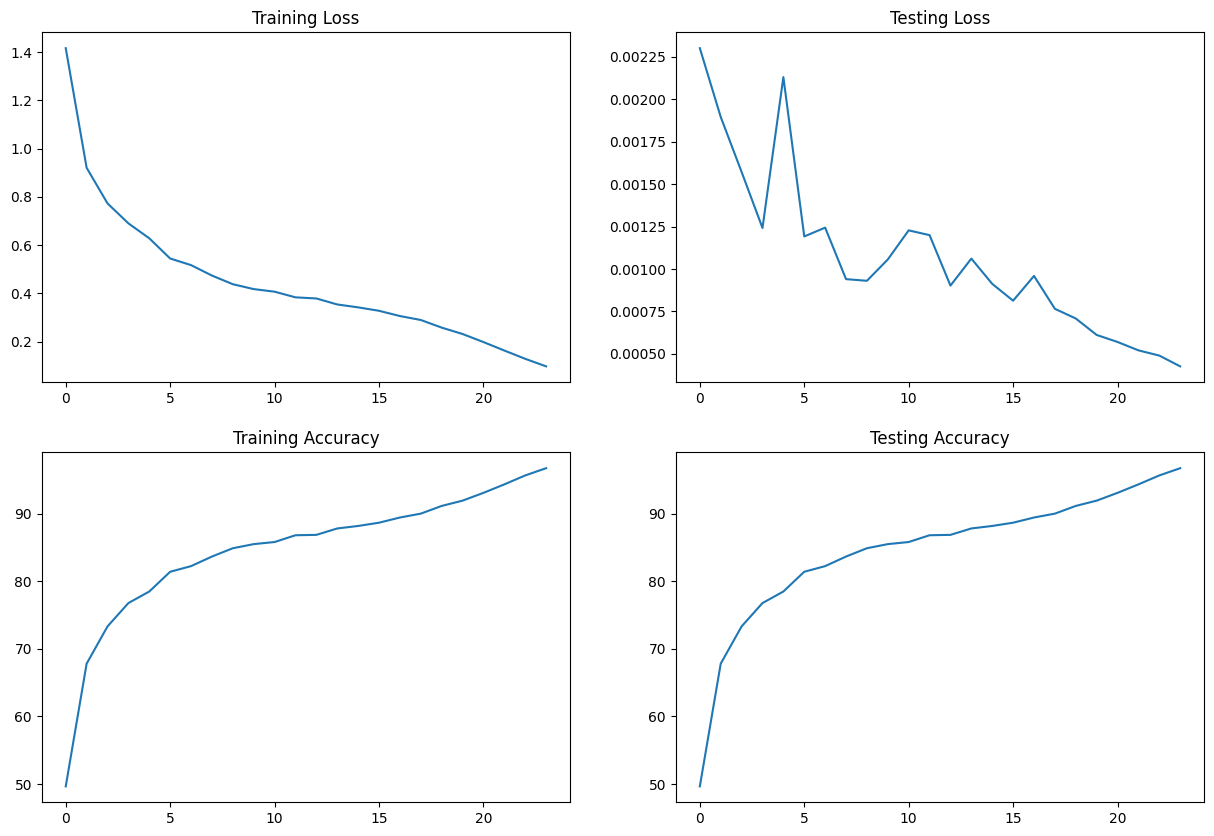

In [11]:
from train import draw_graphs

draw_graphs()